Mount Drive & Main Imports

In [ ]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import re
from abc import ABC, abstractmethod
import random
import pandas as pd
random.seed(42)
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageOps
import numpy as np
from skimage.measure import regionprops, label

# Setting up Paths:

PATH = "/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/"
IMG_PATH = PATH + "All_Leaves/"

# IMG_PATH = PATH + "rawLeafImages/"
# SAVE_VALID_PATH = PATH + "ValidationData/"
# BG_PATH = PATH + "background/"
# MASK_PATH = PATH + "HPSegmentation/"

In [ ]:
# To delete files in directories
# import os

# dir = PATH + 'YOLOv5/images/val'
# for f in os.listdir(dir):
#     os.remove(os.path.join(dir, f))

Importing the relevent functions

In [ ]:
os.chdir("/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/Extra_Modules")
from Cutter import Cutter
from ImageTransformer import ImageTranslator, ImageRotator, ImageReflector, Transformer
from Patcher import Patcher
from utils import getImageFn, getMaskFn, drawBox, writeBBoxesIntoTxtFile
from BoundingBox import BoundingBox
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from torchvision import transforms
from PIL import Image
# import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow


In [ ]:
# Counting no. of images in Leaves Dataset
_, _, files = next(os.walk(IMG_PATH))
t_leaf_count = len(files)
t_leaf_count

1500

#Preprocessing

In [ ]:
labels = ["healthy",
          "low_level_infection",
          "mid_level_infection",
          "high_level_infection",]

In [ ]:
def getLabelWithSubstring(substring, df, labels, mapping):
  count = 0
  for i in df['Label'].unique():

    if substring in labels[i]:
      count += 1
      if substring.lower() not in mapping:
        mapping[substring.lower()] = []
      mapping[substring.lower()].append(i)
      print(i, labels[i])
  print()
  print("A total of: ", count, "labels")


In [ ]:
os.chdir(PATH)
! pwd
df = pd.read_csv("new_disease_small.csv")

/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks


In [ ]:
df

,ID,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
1495,1496,2
1496,1497,2
1497,1498,2
1498,1499,2


In [ ]:
# from PIL import Image
# from pprint import pprint
# # import numpy
# images_array = []

# for image in range(t_leaf_count):
#   leaf_image = Image.open(IMG_PATH+ str(image)+'.png')
#   leaf_array = np.array(leaf_image)
#   images_array.append(leaf_array)

# df['Images'] = images_array # Figure out a more time efficeint way to do this... Actually, only takes ages to display...


In [ ]:
images_src_array = []


for image in range(t_leaf_count):
  leaf_image_src = str(IMG_PATH+ str(image+1)+'.png')
  images_src_array.append(leaf_image_src)

df['Images_src'] = images_src_array # Figure out a more time efficeint way to do this... Actually, only takes ages to display...


In [ ]:
images_src_array[:10]

['/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/All_Leaves/1.png',
 '/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/All_Leaves/2.png',
 '/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/All_Leaves/3.png',
 '/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/All_Leaves/4.png',
 '/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/All_Leaves/5.png',
 '/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/All_Leaves/6.png',
 '/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/All_Leaves/7.png',
 '/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/All_Leaves/8.png',
 '/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/All_Leaves/9.png',
 '/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/All_Leaves/10.png']

In [ ]:
df[:5]

,ID,Label,Images_src
0,1,0,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
1,2,0,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
2,3,0,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
3,4,0,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
4,5,0,/content/gdrive/MyDrive/Leaves_Project/Colab_N...


In [ ]:
mapping = {} # making a dictionary 'mapping' which gets filled with all the labels (healthy, low-level Infection, ...)
df['Label'].nunique()

3

In [ ]:
getLabelWithSubstring("healthy", df, labels, mapping)

0 healthy

A total of:  1 labels


In [ ]:
getLabelWithSubstring("low_level_infection", df, labels, mapping)

1 low_level_infection

A total of:  1 labels


In [ ]:
getLabelWithSubstring("mid_level_infection", df, labels, mapping)

2 mid_level_infection

A total of:  1 labels


In [ ]:
getLabelWithSubstring("high_level_infection", df, labels, mapping)


A total of:  0 labels


In [ ]:
mapping
cat2Code = {'healthy':0, 'low_level_infection':1, 'mid_level_infection':2, 'high_level_infection':3}

def convert2Code(x):
  for key, val in mapping.items():
    if x in val:
      return cat2Code[key]
  return None

def convert2Label(x):
  for key, val in cat2Code.items():
    if x == val:
      return key
  return None

In [ ]:
df['Label'] = df['Label'].apply(lambda x : convert2Code(x))
df['Label'] = df['Label'].apply(lambda x : convert2Label(x))


(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

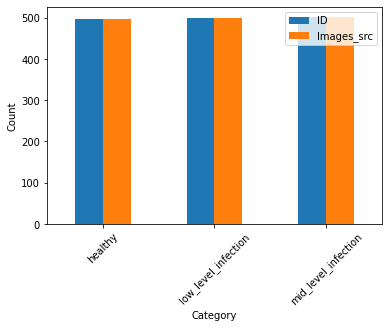

In [ ]:
df.groupby('Label').count().plot.bar()
plt.ylabel('Count')
plt.xlabel('Category')
plt.xticks(rotation=45)

In [ ]:
healthy = df[df['Label']=='healthy']
l_l_inf = df[df['Label']=='low_level_infection']
m_l_inf =  df[df['Label']=='mid_level_infection']
h_l_inf =  df[df['Label']=='high_level_infection']

In [ ]:
healthy

,ID,Label,Images_src
0,1,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
1,2,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
2,3,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
3,4,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
4,5,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
...,...,...,...
493,494,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
494,495,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
495,496,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
496,497,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...


In [ ]:
def split(df, testFrac):
  idx = np.arange(0, len(df))
  # print(len(df))
  stp = len(df)-int(testFrac*len(df))
  # print(stp)
  np.random.shuffle(idx)
  trainIdx, testIdx = idx[:stp], idx[stp:]
  return df.iloc[trainIdx], df.iloc[testIdx]

In [ ]:
def shuffle(df):
  return df.sample(frac=1.0).reset_index(drop=True)

In [ ]:
healthy_train, healthy_test = split(healthy, 0.3)
l_l_inf_train, l_l_inf_test = split(l_l_inf, 0.3)
m_l_inf_train, m_l_inf_test = split(m_l_inf, 0.3)
h_l_inf_train, h_l_inf_test = split(h_l_inf, 0.3)

# bact_train, bact_test = split(bacterial, 0.3)
# mildew_train, mildew_test = split(mildew, 0.3)

In [ ]:
m_l_inf_train

,ID,Label,Images_src
1385,1386,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
1089,1090,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
1013,1014,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
1404,1405,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
1030,1031,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
...,...,...,...
1241,1242,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
1145,1146,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
1365,1366,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
1349,1350,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...


In [ ]:
healthy_test, healthy_valid = split(healthy_test, 0.5)
l_l_inf_test, l_l_inf_valid = split(l_l_inf_test, 0.5)
m_l_inf_test, m_l_inf_valid = split(m_l_inf_test, 0.5)
h_l_inf_test, h_l_inf_valid = split(h_l_inf_test, 0.5)

In [ ]:
trainDf = shuffle(pd.concat([healthy_train, l_l_inf_train, m_l_inf_train, h_l_inf_train]).reset_index(drop=True))
validDf = pd.concat([healthy_valid, l_l_inf_valid, m_l_inf_valid, h_l_inf_valid]).reset_index(drop=True)
testDf = pd.concat([healthy_test, l_l_inf_test, m_l_inf_test, h_l_inf_test]).reset_index(drop=True)


In [ ]:
validDf

,ID,Label,Images_src
0,290,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
1,46,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
2,35,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
3,436,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
4,321,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
...,...,...,...
219,1303,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
220,1196,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
221,1240,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
222,1259,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...


**Moving images to relevent directory**
Copying from the main source to test, train, validation directories depending on how they've been split. The YOLO formated text files will follow.

Takes approx 20 seconds for 1500 pics.

In [ ]:
import glob
import shutil
from os import path

src_dir = IMG_PATH
# dst_dir = PATH + "/" + "Train"


for file in os.listdir(src_dir):
    src_dir = IMG_PATH + file
    name = int(file.split('.')[0])
    # print(train)
    if name in list(trainDf['ID'].values):
      dst_dir = PATH + "YOLOv5/images/train"
      shutil.copy(src_dir, dst_dir)
    elif name in list(testDf['ID'].values):
      dst_dir = PATH + "YOLOv5/images/test"
      shutil.copy(src_dir, dst_dir)
    else:
      dst_dir = PATH + "YOLOv5/images/val"
      shutil.copy(src_dir, dst_dir)


# Image Processing #
Remove background and add bounding box

In [ ]:
def kmeans_foreground(frame, thres=30):
  K = 2

  Z = frame.reshape((-1,3))
  Z = np.float32(Z)

  # define criteria, number of clusters(K) and apply kmeans
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  ret,lbl,center=cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

  center = np.uint8(center)
  res = center[lbl.flatten()]
  res2 = res.reshape((frame.shape))

  # darker centroid
  c = center.sum(axis=1).argmin(axis=0)
  r = tuple([thres]*3)
  mask = cv2.inRange(res2, center[c] - r, center[c] + r)
  return mask

def otsu_foreground(frame, getBright=False, gaussianFilterSize=5):
  n = gaussianFilterSize
  blurred = cv2.GaussianBlur(frame,(n,n),0)
  ret3,th3 = cv2.threshold(blurred.astype("uint8"),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  if getBright:
    return cv2.bitwise_not(th3)
  return th3

def fill_hole_in_binary_mask(mask):
  '''Fills in a closed contour within the binary mask'''

  des = mask.copy()
  contour,hier = cv2.findContours(des,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
  for cnt in contour:
    cv2.drawContours(des,[cnt],0,255,-1)
  return des

def apply_mask(frame, mask):
  return cv2.bitwise_and(frame, frame, mask=mask.astype("uint8"))

In [ ]:
class ImageAligner:
    def __init__(self, masked_item, mask):
        self.masked_item = masked_item
        self.mask = mask

    def alignImage(self):
        rp = max(regionprops(self.mask), key=lambda x: x.area)
        y, x = rp.centroid
        dy = H / 2 - y
        dx = W / 2 - x
        imgTransl = ImageTranslator(dx, dy)
        return imgTransl.transform(self.masked_item, self.mask)

In [ ]:
def writeBBoxesIntoTxtFile(bboxes, savePath, fn, label):
    with open(savePath+str(fn)+".txt", "w") as f:
        for ix, bb in enumerate(bboxes):
            line = "" if ix == len(bboxes) - 1 else "\n"
            s = str(cat2Code[label]) + " " + str(bb) + line
            f.write(s)

In [ ]:
DIM = (128, 128)
# BG_DIM = (1024, 1024)

def load_imgs_from(filenames, path, size=DIM):
  imgs = []
  for fn in tqdm(filenames):
    imgs.append(cv2.resize(plt.imread(path+fn), DIM))
  return imgs

In [ ]:
H, W = 270, 380
# wrap all the methods into a single function
def foreground_separation(frame_lab, frame_rgb):

  l, a, b = cv2.split(frame_lab)

  # separation of objects
  kmeans_rgb_mask = kmeans_foreground(frame_rgb).astype('bool')
  otsu_a_mask = otsu_foreground(a, True).astype('bool')
  otsu_b_mask = otsu_foreground(b, False).astype('bool')

  # construct masking criterions
  A = np.logical_and(kmeans_rgb_mask, otsu_a_mask)
  B = np.logical_and(kmeans_rgb_mask, otsu_b_mask)
  C = np.logical_or(otsu_a_mask, otsu_b_mask)

  # correcting the mask by filling up the holes (closed contours)
  corrected_mask =  fill_hole_in_binary_mask(np.uint8(A|B|C))

  return corrected_mask

In [ ]:
# Bounding box
colourCode = {'healthy':(80, 208, 255), # Light blue
              'low_level_infection': (255, 224, 32), # light yellow
              'mid_level_infection':(255, 160, 16), # orange
              'high_level_infection':(255, 0, 0)} # Red
def drawBox(img, bb, label="healthy"):
    FONT = cv2.FONT_HERSHEY_PLAIN
    x1, y1, x2, y2 = bb.x1, bb.y1, bb.x2, bb.y2
    cv2.rectangle(img, (x1, y1), (x2, y2), colourCode[label], 1)
    cv2.putText(img, label, (x1-15, y2 + 10), FONT, 0.7, colourCode[label], 1)

**Big Loop begin**
This iterates through all the images in all_leaves dir, removes background via segmentation, puts bounding box around and creates the txt file of the bounding box and label information for the later YOLO training.

Takes approx 14 mins for 1500 images...

In [ ]:
# def box_and_path(split_type='train'):
#     Df = split_type + 'Df'
#     print(Df)
#     ind_label = Df.loc[Df['ID'] == i+1, 'Label'].iloc[0]
#     drawBox(img=t_masked_im_copy, bb=bbMask, label=ind_label)
#     save_path = PATH + 'YOLOv5/labels/' + split_type
#     print(save_path)
#     return save_path, ind_label

In [ ]:
box_and_path()

trainDf


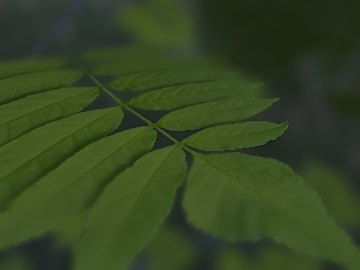

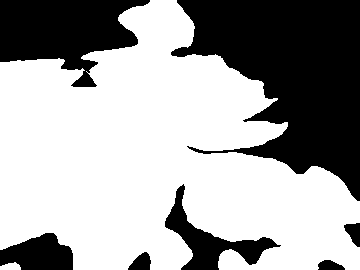

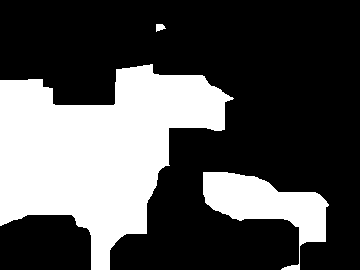

In [ ]:

bbs = []
image = cv2.imread(IMG_PATH + str(12) + '.png')
frame_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
frame_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

corrected_mask = foreground_separation(frame_lab, frame_rgb)
corrected_masked_im = apply_mask(frame_rgb, corrected_mask)

kernel = np.ones((5, 5), np.uint8)
try_p = cv2.erode(corrected_mask, kernel, iterations=9)
cv2_imshow(image)
cv2_imshow(corrected_mask)
cv2_imshow(try_p)

ret, thresh = cv2.threshold(corrected_mask,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

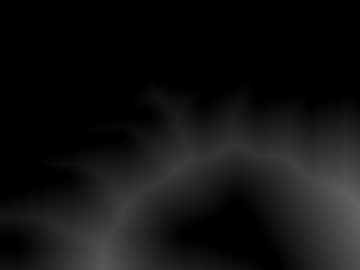

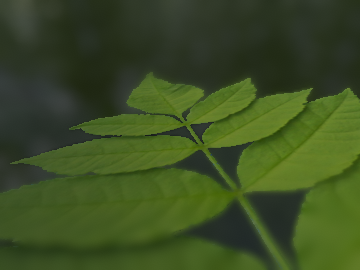

In [ ]:
mask = corrected_mask
kernel = np.ones((2, 2), np.uint8)
mask = cv2.erode(corrected_mask, kernel, iterations=3)

dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2,3)
cv2_imshow(dist_transform)
cv2_imshow(image)

In [ ]:
dist_transform.shape
mask.shape

(270, 360)

In [ ]:
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import skimage.segmentation

local_max_location = peak_local_max(dist_transform, min_distance=1, indices=True)
local_max_boolean = peak_local_max(dist_transform, min_distance=1, indices=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  


In [ ]:
markers, _ = ndi.label(local_max_boolean)
segmented = skimage.segmentation.watershed(255-dist_transform, markers, mask=mask)

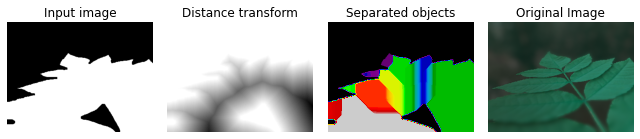

In [ ]:
fig, axes = plt.subplots(ncols=4, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(mask, cmap=plt.cm.gray)
ax[0].set_title('Input image')
ax[1].imshow(-dist_transform, cmap=plt.cm.gray)
ax[1].set_title('Distance transform')
x = ax[2].imshow(segmented, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')
ax[3].imshow(image)
ax[3].set_title('Original Image')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

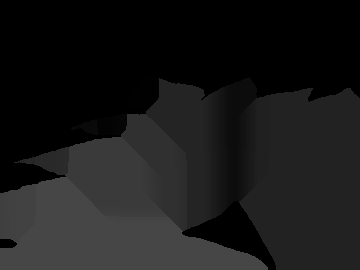

In [ ]:
cv2_imshow(segmented)

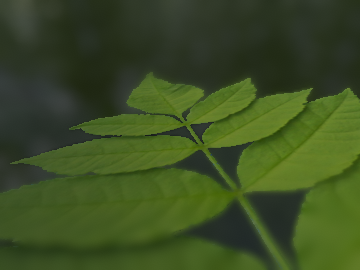

In [ ]:
import cv2
import numpy as np

# Load image

# Set our filtering parameters
# Initialize parameter setting using cv2.SimpleBlobDetector
params = cv2.SimpleBlobDetector_Params()

# Set Area filtering parameters
params.filterByArea = True
params.minArea = 50

# Set Circularity filtering parameters
params.filterByCircularity = True
params.minCircularity = 0.9

# Set Convexity filtering parameters
params.filterByConvexity = True
params.minConvexity = 0.99

# Set inertia filtering parameters
params.filterByInertia = True
params.minInertiaRatio = 0.4

# Create a detector with the parameters
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs
keypoints = detector.detect(image)

# Draw blobs on our image as red circles
blank = np.zeros((1, 1))
blobs = cv2.drawKeypoints(image, keypoints, blank, (0, 0, 255),
                          cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

number_of_blobs = len(keypoints)
text = "Number of Circular Blobs: " + str(len(keypoints))
cv2.putText(blobs, text, (20, 550),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 100, 255), 2)

# Show blobs
cv2_imshow(blobs)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

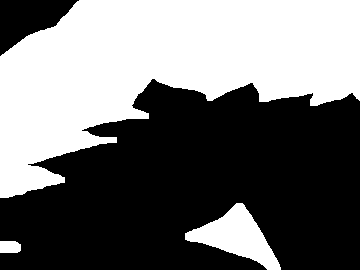

In [ ]:
# noise removal
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

cv2_imshow(unknown)


In [ ]:
 # fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 10))
  # axs = axs.flatten()
  # axs[0].imshow(frame)
  # axs[1].imshow(corrected_masked_im)
  # axs[2].imshow(corrected_mask)
  rp = sorted(regionprops(label(corrected_mask.astype("bool"))),
            key=lambda r: r.area,
            reverse=True,)
  full_im = np.asarray(image)
  h, w = full_im.shape[:2]

  y2, x1, y1, x2 = rp[0].bbox
  bbMask = BoundingBox.fromYOLOFormat(0.5 * (x1 + x2) / w, 0.5 * (y1 + y2) / h, abs(x1 - x2) / w,
                                    abs(y1 - y2) / h, corrected_mask)

  bbMask.convertToOriginalScale()
  # print(bbMask)
  bbs.append(bbMask)

  t_masked_im_copy = np.asarray(image.copy())

  # if i+1 in list(trainDf['ID'].values):
  #   ind_label = trainDf.loc[trainDf['ID'] == i+1, 'Label'].iloc[0]
  #   drawBox(img=t_masked_im_copy, bb=bbMask, label=ind_label)
  #   save_path = PATH + 'YOLOv5/labels/train/'
  #   print('train')
  #   # save_path, ind_label = box_and_path(split_type='train')
  # elif i+1 in list(testDf['ID'].values):
  #   ind_label = testDf.loc[testDf['ID'] == i+1, 'Label'].iloc[0]
  #   drawBox(img=t_masked_im_copy, bb=bbMask, label=ind_label)
  #   save_path = PATH + 'YOLOv5/labels/test/'
  #   print('test')
  #   # save_path, ind_label = box_and_path(split_type='test')
  # else:
  #   ind_label = validDf.loc[validDf['ID'] == i+1, 'Label'].iloc[0]
  #   drawBox(img=t_masked_im_copy, bb=bbMask, label=ind_label)
  #   save_path = PATH + 'YOLOv5/labels/val/'
  #   print('valid')
  #   # save_path, ind_label = box_and_path(split_type='val')

  # cv2_imshow(t_masked_im_copy)

  # writeBBoxesIntoTxtFile(bbs, save_path, i+1 , ind_label)